In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm

In [2]:
#Conversion in IU
G_p = 6.67259e-8 #G in cgs
M_sun = 1.9891e33 #solar mass in g
R_sun = 6.9598e10 #solar radius in cm 
year = 3.14159e7
ly = 9.463e17 #light year in cm
parsec = 3.086e18 #parsec in cm
AU = 1.496e13 #astronomical unit in cm

def v_IU(v_p, M_p=M_sun, r_p=AU):    #because 1 M_i = 1 M_sun and 1 r_i = 1 AU
    return np.sqrt(r_p / (G_p * M_p)) * v_p

def t_IU(t_p, M_p=M_sun, r_p=AU):
    return ((t_p / r_p)*(np.sqrt((G_p * M_p)/r_p)))

t_iu_yr = 6.251839 #1 yr is 6.251839 IU
v_iu_cgs = 3.357e-7 #1 cm/s is 3.357e-7 IU

N = 5000 #Number of particles
a = 3 #Plummer radius

M = 100 #Total mass in IU that corresponds to 5000 solar masses
M_i = M / N #Single particle mass, that is 1 IU

### Don't run again

(0.0, 0.6)

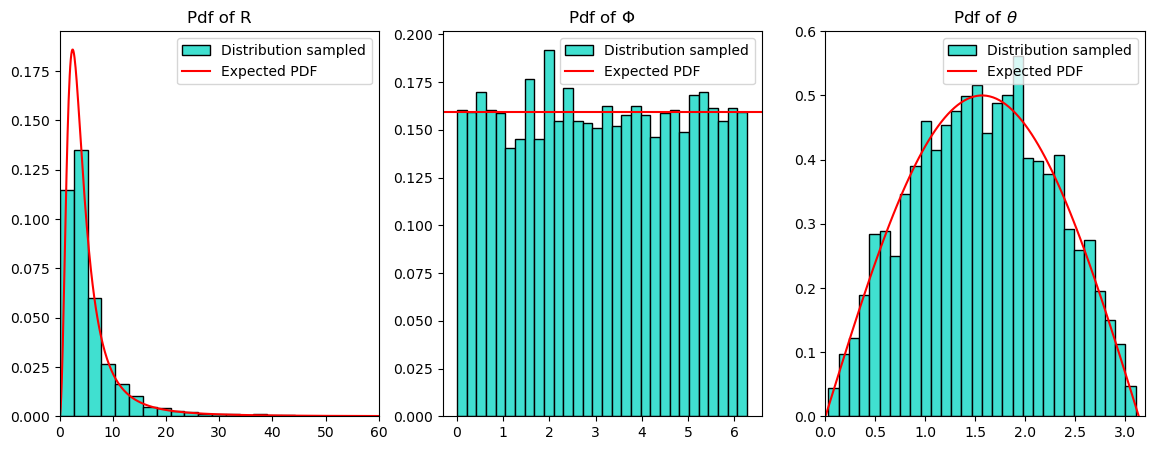

In [45]:
#Sample of the radii, phi and theta
P_r = np.random.uniform(0, 1, N)
r = a * (P_r**(-2/3) - 1)**(-1/2)

phi = np.random.uniform(0, 2*np.pi, N)

P_th=np.random.uniform(0, 1, N)
theta=[]
for i in range(0, N):
    theta=np.append(theta, np.arccos(1-2*P_th[i]))
    
x_grid_r = np.linspace(0, 100,1000)
x_grid_phi = np.linspace(0, 10, 100)
x_grid_th = np.linspace(0, 3.2, 100)

#Check the pdfs
fig, ax = plt.subplots(1, 3, figsize=(14,5))
ax[0].hist(r, bins=100, density = True, edgecolor='black', color='turquoise', label='Distribution sampled')
ax[0].set_title('Pdf of R')
ax[0].set_xlim(0, 60)
ax[0].plot(x_grid_r, (3*x_grid_r**2/a**3)*(1+x_grid_r**2/a**2)**(-5/2), color = 'red', label='Expected PDF')
ax[0].legend()

ax[1].hist(phi, bins=30, density = True, edgecolor='black', color='turquoise', label='Distribution sampled')
ax[1].set_title(r'Pdf of $\Phi$')
ax[1].axhline(1/(2*np.pi), color = 'red', label='Expected PDF')
ax[1].legend()

ax[2].hist(theta, bins=30, density = True, edgecolor='black', color='turquoise', label='Distribution sampled')
ax[2].set_title(r'Pdf of $\theta$')
ax[2].plot(x_grid_th, np.sin(x_grid_th)/2, color = 'red', label='Expected PDF')
ax[2].legend()
ax[2].set_xlim(0, 3.2)
ax[2].set_ylim(0, 0.6)

Text(0.5, 0, 'Z')

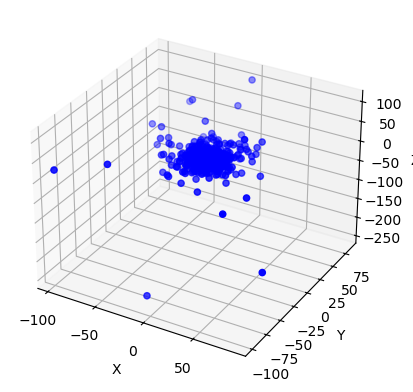

In [46]:
x_0=[]
y_0=[]
z_0=[]

#Converting the positions from spherical coords to cartesian ones 
for i in range(0, N):
    x_0=np.append(x_0, r[i]*np.sin(theta[i])*np.cos(phi[i]))
    y_0=np.append(y_0, r[i]*np.sin(theta[i])*np.sin(phi[i]))
    z_0=np.append(z_0, r[i]*np.cos(theta[i]))

#Showing the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_0, y_0, z_0, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

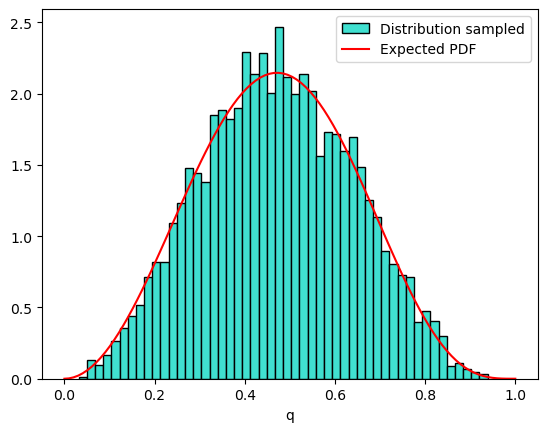

In [51]:
#Sample the velocities from the distribution function f(eps)

C_normalization = 0.04295146206444051 

f = lambda q: (1 - q**2)**(7/2) * q**2/C_normalization  #lambda function: defining a function without def, because we use it only here
max_f = np.max(f(np.linspace(0, 1, 1000)))
        
q_samples = []
        
while len(q_samples) < N:
    q_rand = np.random.uniform(0, 1)
    y = np.random.uniform(0, max_f)
            
    if y < f(q_rand):
        q_samples.append(q_rand)

#Check the pdf of q
plt.hist(q_samples, bins=50, density=True, color='turquoise', label='Distribution sampled', edgecolor='black')
x_grid_q = np.linspace(0, 1, 100)
plt.plot(x_grid_q, f(x_grid_q), color='red', label='Expected PDF')
plt.xlabel('q')
plt.legend();

In [52]:
psi_IU = M / np.sqrt(r**2 + a**2) #Potential in IU
v = q_samples * np.sqrt(2 * psi_IU)
        
v_phi = 2 * np.pi * np.random.uniform(0, 1, N)
v_theta = np.arccos(1 - 2 * np.random.uniform(0, 1, N))  

vx_0 = v * np.cos(v_phi) * np.sin(v_theta)
vy_0 = v * np.sin(v_phi) * np.sin(v_theta)
vz_0 = v * np.cos(v_theta)

In [53]:
starting_time=0
num_dimensions=3
m=np.ones(N)/50 #mass of each particle in internal units

with open("Plummer5000.in", "w") as f:     
    print(N, num_dimensions, starting_time, sep="\n", file=f)
    np.savetxt(f, np.column_stack([m]), delimiter=" ")  
    np.savetxt(f, np.column_stack([x_0, y_0, z_0]), delimiter=" ")
    np.savetxt(f, np.column_stack([vx_0, vy_0, vz_0]), delimiter=" ")

Command: ./treecode in=Plummer5000.in out=out_plum_eq_5000_01.out dtime=0.1 eps=0.1 theta=0.1 tstop=5 dtout=0.1 > energy_plum_5000_01.log

In [3]:
#per il momento sono tutti in IU
def GetData(filename, N):
    file_output = open(filename, "r")
    output = file_output.read().splitlines()
    data = []
    time = []
    
    for i in range(3, len(output), 3 * N + 3):
        for j in range(N, 3 * N):
            data.append(output[i + j].split())
        
        time.append(float(output[i - 1]))
        
    #Convert the time in years
    #time = np.array(time) / t_iu_yr
    
    file_output.close()
    
    return np.array(data), np.array(time)

#Get the evolution in time from the data in the CM frame

def GetCoords(data, t, N):
    
    #Get the coordinates
    
    x_ext, y_ext, z_ext = [], [], []
    
    for i in range(0, len(t)):
        x_ext.append([])
        y_ext.append([])
        z_ext.append([])
        
    #Every row contains the coordinate of the i-th particle, every column contains its evolution in time
    
    row = 0
    
    for i in range(0, len(data), 2 * N):    
        for j in range(0, N):
            x_ext[row].append(float(data[i + j][0]))
            y_ext[row].append(float(data[i + j][1]))
            z_ext[row].append(float(data[i + j][2]))
        
        row += 1
    
    #Convert the coordinates to the CM frame
        
    x_ext = np.array(x_ext)
    y_ext = np.array(y_ext)
    z_ext = np.array(z_ext)
    
    x_CM = M_i * np.sum(x_ext, axis=1) / M   #le masse sono tutte uguali
    y_CM = M_i * np.sum(y_ext, axis=1) / M
    z_CM = M_i * np.sum(z_ext, axis=1) / M
    r_CM = np.sqrt(x_CM**2 + y_CM**2 + z_CM**2)
    
    x = x_ext - x_CM[0]
    y = y_ext - y_CM[0]
    z = z_ext - z_CM[0]

    return x, y, z, r_CM


#Get the velocities in time in the CM frame

def GetVelocities(data, t, N):
    
    #Get the coordinates
    
    vx_ext, vy_ext, vz_ext = [], [], []
    
    for i in range(0, len(t)):
        vx_ext.append([])
        vy_ext.append([])
        vz_ext.append([])
        
    #Every row contains the coordinate of the i-th particle, every column contains its evolution in time
    
    row = 0
    
    for i in range(N, len(data), 2 * N):    
        for j in range(0, N):
            vx_ext[row].append(float(data[i + j][0]))
            vy_ext[row].append(float(data[i + j][1]))
            vz_ext[row].append(float(data[i + j][2]))
        
        row += 1
    
    #Convert the coordinates to the CM frame
        
    vx_ext = np.array(vx_ext)
    vy_ext = np.array(vy_ext)
    vz_ext = np.array(vz_ext)
    
    vx_CM = M_i * np.sum(vx_ext, axis=1) / M
    vy_CM = M_i * np.sum(vy_ext, axis=1) / M
    vz_CM = M_i * np.sum(vz_ext, axis=1) / M
    
    K_CM = M * (vx_CM**2 + vy_CM**2 + vz_CM**2) / 2   #energia cinetica del centro di massa 
    
    vx = vx_ext - vx_CM[0]
    vy = vy_ext - vy_CM[0]
    vz = vz_ext - vz_CM[0]

    v_CM = np.sqrt(vx_CM**2 + vy_CM**2 + vz_CM**2)

    return vx, vy, vz, K_CM, v_CM

In [9]:
data, t = GetData("out_plum_eq_5000_01.out", N)
x, y, z, R_CM = GetCoords(data, t, N)
vx, vy, vz, K_CM, v_CM = GetVelocities(data, t, N)

In [11]:
#Compute relaxation timescale (when the initial velocity distribution becomes Maxwellian)
r = np.sqrt(x**2 + y**2 + z**2)    
n_rel = N / (8 * np.log(N))
#t_cross = np.median(r) / np.median(np.sqrt(vx_0**2 + vy_0**2 + vz_0**2))
#t_rel = t_cross * n_rel

#print("\nCrossing time: t_cross =" + f"{t_cross / t_iu_yr: .3f}" + " yr =" + f"{t_cross: .3f}" + " IU")
#print("Relaxation time: t_rel =" + f"{t_rel / t_iu_yr: .3f}" + " yr =" + f"{t_rel: .3f}" + " IU")

volume = 4/3 * np.pi * a**3

density_0 = M / volume #Initial density

t_dyn_IU = np.sqrt(3 * np.pi / (16 * density_0))  #G_i=1!
t_dyn = t_dyn_IU / t_iu_yr
print("Dynamical time: t_dyn =" + f"{t_dyn: .3f}" + " yr =" + f"{t_dyn_IU: .3f}" + " IU")

Dynamical time: t_dyn = 0.131 yr = 0.816 IU


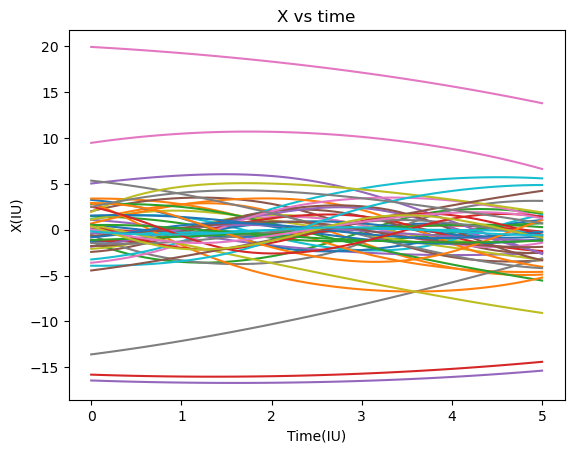

In [12]:
x_1 = np.zeros(len(t))
plt.title("X vs time")
plt.xlabel("Time(IU)")
plt.ylabel("X(IU)")
for j in range(0, N, 100):
    for i in range(len(t)):
        x_1[i] = x[i][j]
    plt.plot(t, x_1)

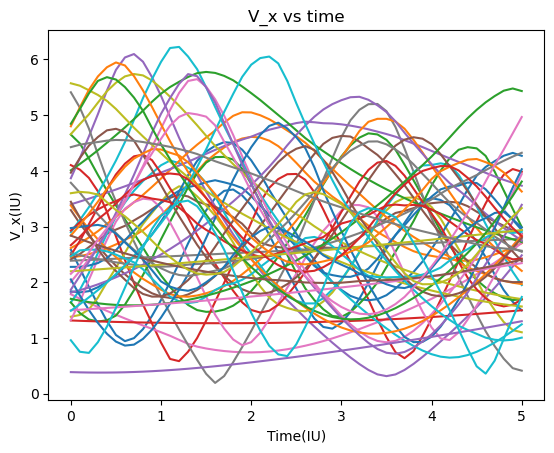

In [13]:
v = np.sqrt(vx**2 + vy**2 + vz**2)
plt.title("V_x vs time")
plt.xlabel("Time(IU)")
plt.ylabel("V_x(IU)")
v1 = np.zeros(len(t))
for j in range(0, N, 100):
    for i in range(len(t)):
        v1[i] = v[i][j]
    plt.plot(t, v1)

## Energy analysis
Check if the total energy remains constant over the time 

In [14]:
def GetEnergy(filename, N, K_CM):
    file_output = open(filename, "r")
    output = np.array(file_output.read().splitlines())
    
    idx = np.where(output == output[9])[0] #Find the row with T and U
    
    K = []
    U = []
    
    for i in idx:
        K.append(float(output[i + 1].split()[1]))
        U.append(-float(output[i + 1].split()[2]))
        
    K = (np.array(K) - K_CM) #* M_sun / v_iu_cgs**2
    U = np.array(U) #* G_p * M_sun**2 / AU

    E = K + U
    
    file_output.close()
    
    return E, K, U 
    
E, K, U = GetEnergy("energy_plum_5000_01.log", N, K_CM)

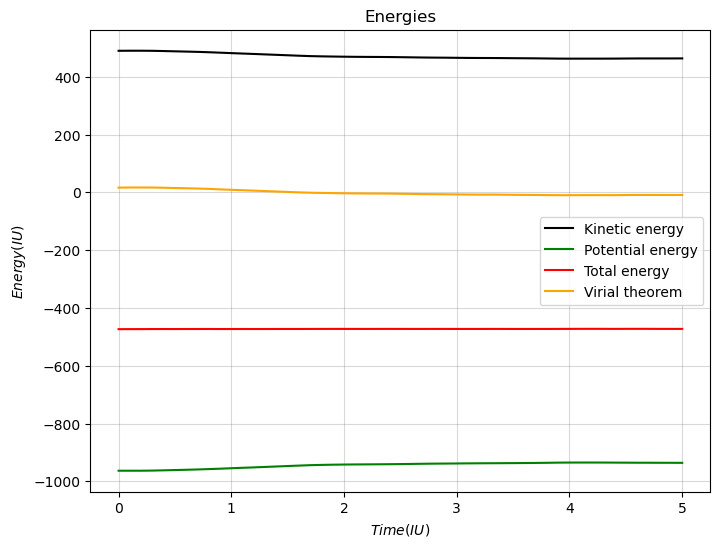

In [15]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.gca()
ax1.grid(alpha=0.3, c = 'grey')
ax1.set_xlabel('$Time(IU)$')
ax1.set_ylabel('$Energy(IU)$')
ax1.plot(t, K, label = 'Kinetic energy', c= 'black')
ax1.plot(t, U, label = 'Potential energy', c= 'green')
ax1.plot(t, E, label = 'Total energy', c= 'red')
ax1.plot(t, 2*K+U, label = 'Virial theorem', c = 'orange')
ax1.set_title('Energies')
ax1.legend()

## Evaluate the density profile as function of the radius
Does it follow the analytical model?

In [16]:
#Define the radius edges for binning
radii = np.linspace(np.min(r), np.max(r), 100)

#Arrays to store density profiles for each frame
num_part_shell = np.zeros((len(r), len(radii)-1))
volumes = np.zeros(len(radii)-1)
densities = np.zeros((len(r), len(radii)-1))

#Calculate shell volumes once (same for all frames)
for i in range(len(radii)-1):
    volumes[i] = 4/3 * np.pi * (radii[i+1]**3 - radii[i]**3)

#Process each frame
for f in range(len(r)):
    #Use histogram to count particles in each radial bin for this frame
    num_part_shell[f], _ = np.histogram(r[f], bins=radii)
    
    #Calculate density for this frame
    densities[f] = M_i * num_part_shell[f] / volumes

#Now densities[j][i] gives the density in the i-th shell for the j-th frame

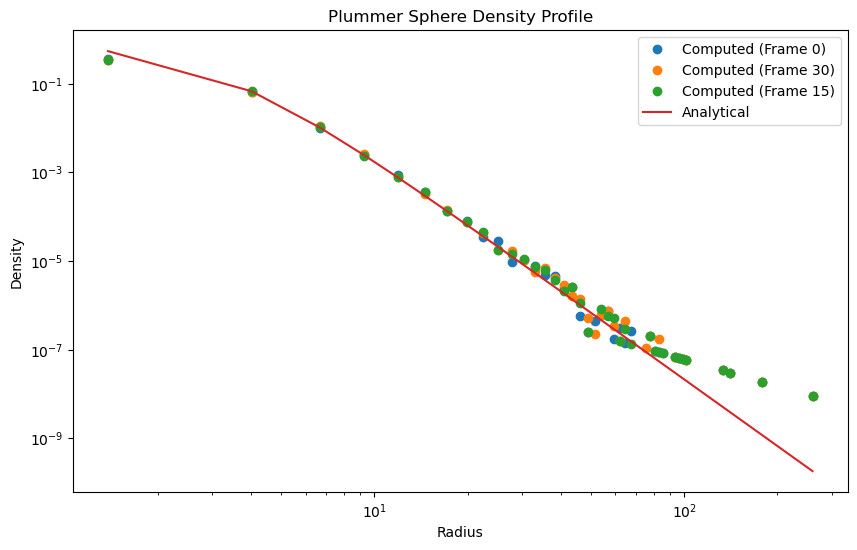

In [17]:
# Analytical Plummer profile for comparison (using scale length 'a' and total mass 'M')
r_centers = 0.5 * (radii[1:] + radii[:-1])  # Centers of the bins
plummer_density = (3*M/(4*np.pi*a**3)) * (1 + (r_centers/a)**2)**(-5/2)

# Plot comparison (for a specific frame, e.g., frame 0)
plt.figure(figsize=(10, 6))
plt.loglog(r_centers, densities[0], 'o', label='Computed (Frame 0)')
plt.loglog(r_centers, densities[30], 'o', label='Computed (Frame 30)')
plt.loglog(r_centers, densities[15], 'o', label='Computed (Frame 15)')
plt.loglog(r_centers, plummer_density, '-', label='Analytical')
plt.xlabel('Radius')
plt.ylabel('Density')
plt.title('Plummer Sphere Density Profile')
plt.legend()
#plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.show()

In [18]:
import os
import imageio.v2 as imageio

# Toggle on/off the movie maker
make_movie = True

if make_movie:
    # FOLDERS MANAGING
    movie_dir_path = "movie"
    frames_dir_path = os.path.join(movie_dir_path, "frames")
    movie_frame_name_prefix = "snapshot_img_"

    # Create folders to store the movie and its frames
    if not os.path.isdir(movie_dir_path):
        os.makedirs(frames_dir_path)
    
    # Empty the 'frames' folder
    for file_name in os.listdir(frames_dir_path):
        file_path = os.path.join(frames_dir_path, file_name)
        os.remove(file_path)
    
    # Empty the 'movie' folder
    for file_name in os.listdir(movie_dir_path):
        file_path = os.path.join(movie_dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

    # GENERATING FRAMES
    N_frames = len(t)  # Assumiamo che "t" sia la lista dei tempi

    delete_frames = True  # Se vuoi i frames metti False

    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect(None, zoom=0.9)  # To prevent z-axis label from being cut off

    # For every snapshot (or for some of them depending on the step of the range() call)
    # plot the position of every particle in 3D space
    for i in range(N_frames):
        for j in range(N):
            ax.scatter(x[i][j], y[i][j], z[i][j], color="blue")

        if i == 0:
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            z_lim = ax.get_zlim()
        
        ax.set_aspect('equal', 'datalim')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)

        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")

        # Save the current figure with a proper name
        frame_name = movie_frame_name_prefix + str(i).zfill(5) + ".png"
        frame_path = os.path.join(frames_dir_path, frame_name)
        fig.savefig(frame_path)

        # Clear the axes for the next plot
        ax.clear()

    plt.close()

    # ASSEMBLING FRAMES
    movie_img_files = os.listdir(frames_dir_path)
    movie_img_files = sorted(movie_img_files)

    movie_path = os.path.join(movie_dir_path, "movie.mp4")

    # Use the imageio writer to build the movie by appending to it every frame
    # Default fps is 10
    with imageio.get_writer(movie_path, mode='I', fps=10) as writer:
        for filename in movie_img_files:
            image = imageio.imread(os.path.join(frames_dir_path, filename))  # Get the frame
            writer.append_data(image)  # Append the frame

    # Delete individual frames if requested
    if delete_frames:
        for file_name in os.listdir(frames_dir_path):
            file_path = os.path.join(frames_dir_path, file_name)
            os.remove(file_path)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 900) to (1600, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
